# Defect Detection for 3D Printing 

## Goal
The goal of this project is to develop a Defect Detection Algorithm for additive manufacturing processes. This algorithm will monitor ongoing 3D printing and automatically stop the printer if the probability of a defect exceeds 85%, thereby reducing wasted material and improving production efficiency.

---

### Current Solutions and Challenges

#### 1. **Implementation Based on Research Paper**
- **Model Used**: EfficientDet-Lite
- **Methodology**:
  - Utilized transfer learning to adapt the EfficientDet-Lite model to additive manufacturing defect detection.
  - The pre-trained EfficientDet-Lite model (originally trained on the COCO 2017 dataset) was fine-tuned with a small dataset of 120 images related to additive manufacturing.
  - During fine-tuning:
    - The last few layers of the model were replaced to suit the number of object classes.
    - Pre-trained weights were frozen, and only the newly added layers were trained.
- **Challenges**:
  - The dataset was extremely small (120 images), making the model prone to overfitting and reducing its ability to generalize.
  - The small dataset limits the model's applicability to real-world scenarios with more variability.

---

#### 2. **Kaggle Implementation**
- **Dataset Used**: A larger and more balanced dataset from Kaggle:
  - 759 defected images.
  - 798 non-defected images.
- **Improvements Over Paper**:
  - The dataset is significantly larger than the one used in the paper, improving balance and generalization.
- **Challenges in Current Implementation**:
  - **Overfitting**:
    - The model tends to memorize training data rather than generalize to unseen examples.
  - **Fluctuations in Loss**:
    - Validation loss exhibits high instability, indicating potential issues with training configuration or data variability.
  - **No Test Set**:
    - Only training and validation splits are used, making it difficult to assess the model's true generalization performance.

---

### Planned Solutions

#### 1. **Data Augmentation**:
   - Implement aggressive yet realistic data augmentation techniques to increase the size and diversity of the dataset:
     - Random rotation.
     - Horizontal/vertical flips.
     - Brightness, contrast, and saturation adjustments.
     - Adding random noise.
   - This will help the model generalize better and prevent overfitting.

#### 2. **Regularization**:
   - Introduce L2 regularization to penalize large weights and improve the model's robustness.
   - Adjust dropout rates to balance regularization without causing underfitting.

#### 3. **Improved Dataset Handling**:
   - Split the Kaggle dataset into training, validation, and test sets to properly evaluate the model's performance on unseen data.
   - Collect additional defect and non-defect data during every print session to enlarge the dataset for future iterations.

#### 4. **Fine-Tuning Strategy**:
   - Rather than freezing all pre-trained weights, only the first 10 layers of the model will be frozen. The rest of the layers and newly added classification layers will be fine-tuned on the dataset.
   - This allows the model to adapt its deeper features to the domain of additive manufacturing.

#### 5. **Monitoring Training Performance**:
   - Introduce:
     - Learning rate scheduling to dynamically adjust the learning rate.
     - Early stopping to halt training when validation loss stops improving.
   - Use cross-validation to ensure consistent performance across different splits of the dataset.

#### 6. **Real-Time Data Collection and Feedback**:
   - Automate data collection during each printing session:
     - Save images from the printer's camera feed and label them based on defect detection results.
   - Use this data to continuously improve the model by retraining with an expanded dataset.

---

### Expected Outcomes
- **Improved Generalization**:
  - Data augmentation and regularization will help reduce overfitting and stabilize loss fluctuations.
- **Reliable Evaluation**:
  - With the addition of a test set, the model's true performance will be assessed more effectively.
- **Future-Proofing**:
  - By collecting new data during real-time operation, the dataset will continuously grow, allowing for better future iterations.
- **Real-Time Defect Detection**:
  - The model will monitor the printing process in real-time and stop the printer automatically if a defect is detected with a probability of over 85%.

This implementation builds on existing research while addressing key limitations, making it more applicable for real-world scenarios.


In [ ]:
#Importing Necessary Libraries 

import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf

from sklearn.model_selection import KFold


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomContrast, RandomBrightness
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation


In [2]:
batch_size = 256
img_height = 180
img_width = 180

In [3]:
# import os
# import random
# import shutil

# # Paths
# data_dir = "./Data"  # Update with the path to your `Data` folder
# trainval_dir = os.path.join(data_dir, "TrainVal")
# test_dir = os.path.join(data_dir, "Test")

# # Create new directories for TrainVal and Test
# os.makedirs(os.path.join(test_dir, "defected"), exist_ok=True)
# os.makedirs(os.path.join(test_dir, "no_defected"), exist_ok=True)
# os.makedirs(os.path.join(trainval_dir, "defected"), exist_ok=True)
# os.makedirs(os.path.join(trainval_dir, "no_defected"), exist_ok=True)

# # Helper function to move images
# def move_images(src_folder, dst_trainval, dst_test, category):
#     files = os.listdir(src_folder)
    
#     if not files:
#         print(f"No images found in {category}. Skipping.")
#         return
    
#     random.shuffle(files)
#     test_count = int(0.1 * len(files))  # Allocate 10% for testing
    
#     for file in files[:test_count]:
#         shutil.move(os.path.join(src_folder, file), os.path.join(dst_test, file))
    
#     for file in files[test_count:]:
#         shutil.move(os.path.join(src_folder, file), os.path.join(dst_trainval, file))
    
#     print(f"Moved {test_count} images to Test/{category}.")
#     print(f"Moved {len(files) - test_count} images to TrainVal/{category}.")

# # Move images for defected
# move_images(
#     os.path.join(data_dir, "defected"),
#     os.path.join(trainval_dir, "defected"),
#     os.path.join(test_dir, "defected"),
#     "defected"
# )

# # Move images for no_defected
# move_images(
#     os.path.join(data_dir, "no_defected"),
#     os.path.join(trainval_dir, "no_defected"),
#     os.path.join(test_dir, "no_defected"),
#     "no_defected"
# )

# print("Dataset split completed!")


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory = "./Data/TrainVal",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1403 files belonging to 2 classes.
Using 1123 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory = "./Data/TrainVal",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1403 files belonging to 2 classes.
Using 280 files for validation.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="./Data/Test",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 154 files belonging to 2 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)

['defected', 'no_defected']


In [8]:
num_classes = len(class_names)
print(num_classes)

2


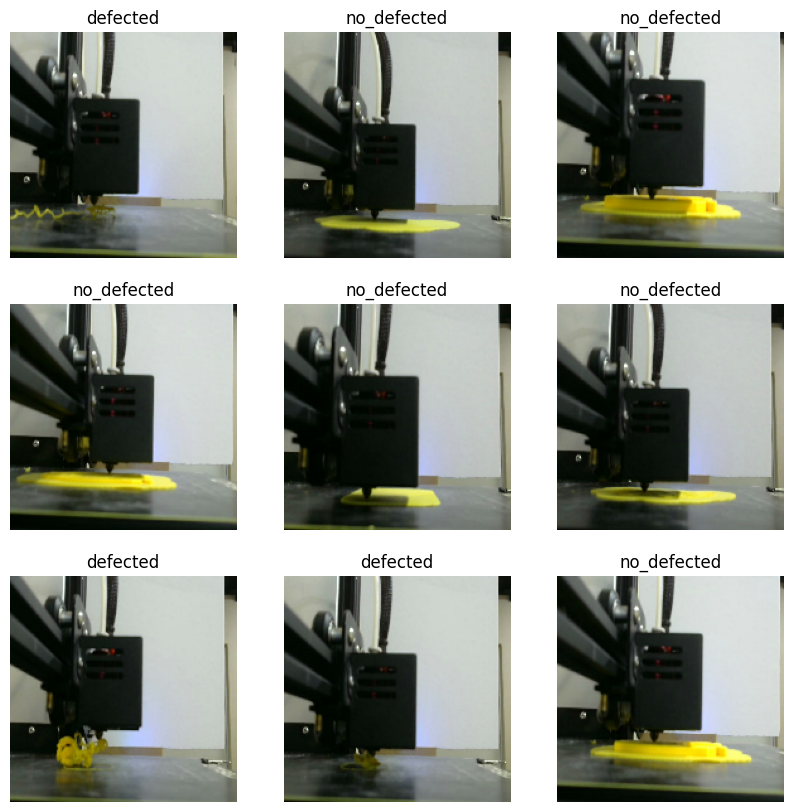

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(256, 180, 180, 3)
(256,)


In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
  ]
)

c:\Users\Charbel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


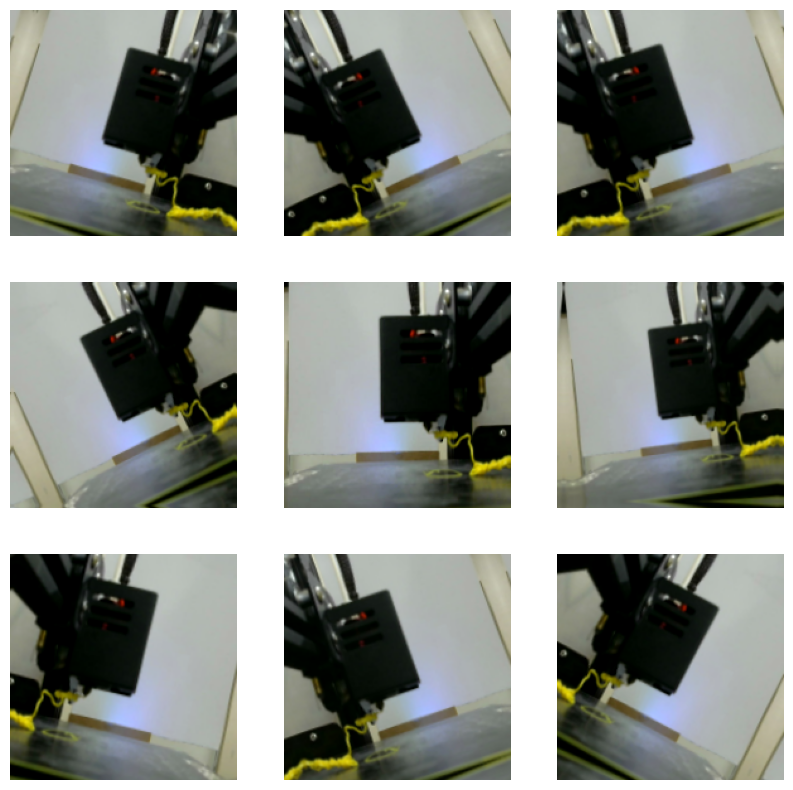

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [14]:
# Normalize datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [15]:
# Configure datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
for images, labels in train_ds.take(1):
    print(f"Training Images batch shape: {images.shape}")
    print(f"Training Labels batch shape: {labels.shape}")

for images, labels in val_ds.take(1):
    print(f"Validation Images batch shape: {images.shape}")
    print(f"Validation Labels batch shape: {labels.shape}")

for images, labels in test_ds.take(1):
    print(f"Test Images batch shape: {images.shape}")
    print(f"Test Labels batch shape: {labels.shape}")


Training Images batch shape: (256, 180, 180, 3)
Training Labels batch shape: (256,)
Validation Images batch shape: (256, 180, 180, 3)
Validation Labels batch shape: (256,)
Test Images batch shape: (154, 180, 180, 3)
Test Labels batch shape: (154,)


In [ ]:
model = Sequential([
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='leaky_relu',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='leaky_relu',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='leaky_relu',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu', 
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dense(num_classes, activation="sigmoid", name="outputs")
])


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,  
    decay_rate=0.9     
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.keras',  
        monitor='val_loss',
        save_best_only=True
    )
]


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 605ms/step - accuracy: 0.4988 - loss: 1.1916 - val_accuracy: 0.5143 - val_loss: 1.0115
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step - accuracy: 0.4806 - loss: 1.0129 - val_accuracy: 0.7679 - val_loss: 0.9504
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - accuracy: 0.6124 - loss: 0.9418 - val_accuracy: 0.8036 - val_loss: 0.8583
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 534ms/step - accuracy: 0.6772 - loss: 0.8654 - val_accuracy: 0.6821 - val_loss: 0.8172
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - accuracy: 0.6953 - loss: 0.7937 - val_accuracy: 0.7357 - val_loss: 0.6957
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - accuracy: 0.7612 - loss: 0.7099 - val_accuracy: 0.7321 - val_loss: 0.6406
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - accuracy: 0.7351 - loss: 0.6795 - val_accuracy: 0.8536 - val_loss: 0.5996
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - accuracy: 0.8105 - loss: 0.6359 - val_accuracy: 0.8536 - val_loss:

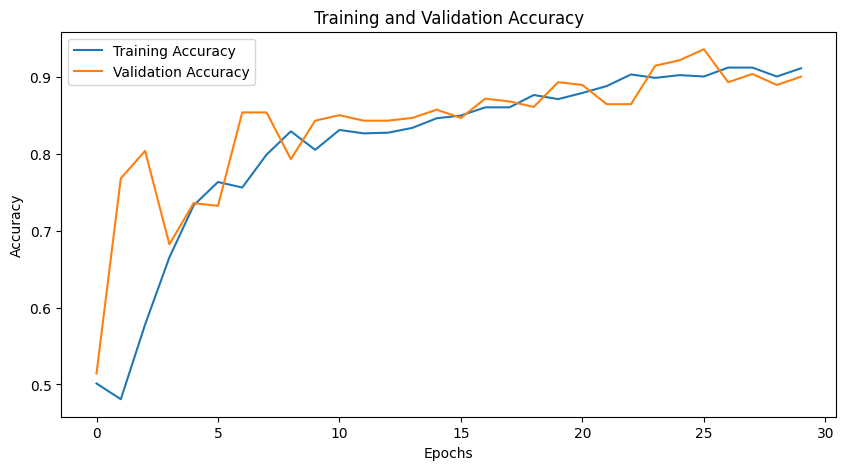

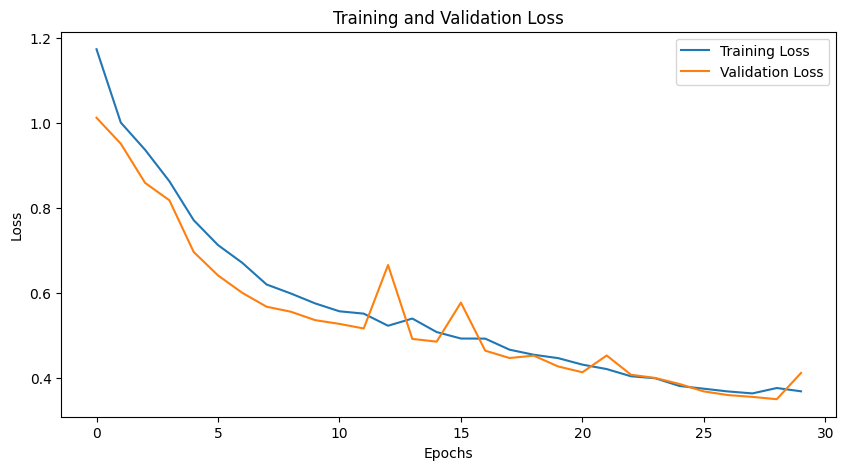

In [22]:
# Plot Training and Validation Metrics

# Extract history
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9286 - loss: 0.3381
Test Loss: 0.3381
Test Accuracy: 0.9286
